# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.3: Ordinary Least Squares

### 1.3.1 Ordinary Least Squares

The Ordinary Least Squares (hereafter OLS) algorithm is a key algorithm for prediction, regression and many other learning tasks. Despite it initially looking like *just* a linear algorithm, it can be extended to be able to predict a wide variety of complex tasks. It is a powerful algorithm with some solid mathematical proofs behind it, and is a very practically useful algorithm for prediction and modelling tasks.

We will review the OLS algorithm in significant depth over the next few notebooks, and use it extensively over the rest of this course.
The OLS algorithm aims to solve problems of the form:

$ Y = X\beta + \boldsymbol{u}$

Where:
* $Y$ is the variable we are attempting to predict (the dependent variable)
* $X$ is our independent variable (or multiple variables, as we will see in the next notebook)
* $\beta$ is the parameters we are trying to learn
* $u$ is the error of our model, as we can often not predict data perfectly.

This type of model is a **Linear Regression Model**, as the model is a linear combination of $X$ and $\beta$. Note, however, that the values of $X$ do not have to be linear, for instance, we can used $x^2$ as our $X$ value, and we still use Linear Regression to learn that model (although in some cases it may no longer be the best algorithm - a problem for later). We use OLS to find the best values for $\beta$ for our Linear Regression Model.

OLS aims to learn the *best* values for $\beta$, which is defined as the values that minimise the value $u$, our error. Before we get to how to do that, we will have a look at the Linear Regression Model in more detail.

### Linear Regression Model

In a Linear Regression Model, we have our independent $X$ values, and our dependent $Y$ values, and we wish to find a linear relationship between them. For instance:

In [1]:
%run setup.ipy

In [2]:
prices = pd.read_hdf("data/HousePricesVsInterestRates.hdf", key="NSW")

In [3]:
prices.head()

,MedianPrice,CashRate
2007-03-31,517447.312500,6.25
2007-06-30,528379.733333,6.25
2007-09-30,511257.021277,6.50
2007-12-31,547164.071090,6.75
2008-03-31,567444.245132,7.25


In [4]:
# Divide the MedianPrice by 1000 to get easier numbers to work with
prices['MedianPrice'] /= 1000

In [5]:
alt.Chart(prices).mark_circle().encode(
    x='CashRate',
    y='MedianPrice'
).properties(
    width=800,
    height=300
)

alt.Chart(...)

In this data, there is a linear relationship between the Cash Interest Rate and House Prices that we will attempt to model.

Side note: while there is a causual relationship between the two (a lower cash rate gives more people the ability to take out loans), the linear relationship here is a drastic oversimplification of things. For instance, the interest rate has been in relatively steady decline for a while, while house prices have gone up, and generally would have due to inflation anyway. A more formal analysis would need to remove the effect of inflation and other impacts.

In [6]:
data_chart = alt.Chart(prices).mark_circle().encode(
    x='CashRate',
    y='MedianPrice'
)


x = np.arange(0, 8.25, 0.25)

m = -100
c = 1100

y = m * x + c

model = pd.DataFrame({'x': x, 'y':y})


linear_model_chart = alt.Chart(model).mark_line().encode(
    x='x', y='y'
)

(data_chart + linear_model_chart).properties(
    width=800,
    height=300
)

alt.LayerChart(...)

Quite a good fit! We can then work out our error, by using our "model" where $\beta=4$ and a constant of 300 (we will see how this fits into a model soon), on the actual hours studied, and compare that to the actual scores:

In [7]:
predicted_prices = prices['CashRate'] * m + c  # Same values as before - this is our "model"
error = np.sum(np.abs(predicted_prices - prices['MedianPrice']))  # The "absolute error"
print("The error is {:.2f}".format(error))

The error is 4935.24


The OLS algorithm aims to minimise the squared error, which is:

In [8]:
squared_error = np.sum((predicted_prices - prices['MedianPrice']) ** 2)
print("The squared error is {:.2f}".format(squared_error))

The squared error is 689865.92


Both errors are valid to use, but the squared error is nicer from an algebraic perspective, allowing for gradients to be computed, and automatically account for positive/negative errors in the same way.

#### Exercises

1. Why wouldn't you use the actual error, that is `np.sum(predicted_prices - prices['MedianPrice'])`?
2. Try three different models (change the values of m and c in the equation before). What is your best performing model?

In [14]:
m = -100
c = 1100
predicted_prices = prices['CashRate'] * m + c  # Same values as before - this is our "model"
error = np.sum(np.abs(predicted_prices - prices['MedianPrice']))  # The "absolute error"
print("The error is {:.2f}".format(error))

squared_error = np.sum((predicted_prices - prices['MedianPrice']) ** 2)
print("The squared error is {:.2f}".format(squared_error))

m = -110
c = 1000
predicted_prices = prices['CashRate'] * m + c  # Same values as before - this is our "model"
error = np.sum(np.abs(predicted_prices - prices['MedianPrice']))  # The "absolute error"
print("The error is {:.2f}".format(error))

squared_error = np.sum((predicted_prices - prices['MedianPrice']) ** 2)
print("The squared error is {:.2f}".format(squared_error))

m = -90
c = 1000
predicted_prices = prices['CashRate'] * m + c  # Same values as before - this is our "model"
error = np.sum(np.abs(predicted_prices - prices['MedianPrice']))  # The "absolute error"
print("The error is {:.2f}".format(error))

squared_error = np.sum((predicted_prices - prices['MedianPrice']) ** 2)
print("The squared error is {:.2f}".format(squared_error))

The error is 4935.24
The squared error is 689865.92
The error is 5181.09
The squared error is 906373.12
The error is 4083.08
The squared error is 468521.42


*For solutions, see `solutions/linear_regression_intro.py`*

### Ordinary Least Squares Derivation

Here we will go through the derivation of the OLS algorithm with matrix mathematics. We will extend this further in the next notebook where we look at multivariate OLS. Before we do that, we will extend our Linear Regression Model slightly to account for our constant value (the "c" in our model for house prices):

$ Y = X\beta + \boldsymbol{u}$  (as before)

where $\beta = [\beta_1, \beta_2]$ and $X = [1, X]$.

In other words, $\beta$ is two values - the multiplier against the constant (hereafter just "the constant") and the value that the independent variable is multiplied against ($X\beta_2$). We extend $X$ by adding a column of 1s to it, and then use matrix multiplication, as we will review in the next notebook. This multiplies the 1s by the constant and also the independent variable by its coefficient.

The aim of OLS is to choose $\beta$ to minimise $u^2$ (the squared error), which we can do via the following equations:

$ \boldsymbol{y}  = X\beta + u$ 

$ \boldsymbol{u} = \boldsymbol{y} - X\beta $

$\boldsymbol{u}^2 = \boldsymbol{u}\boldsymbol{u} = (\boldsymbol{y} - X\beta)(\boldsymbol{y} - X\beta)$

$\boldsymbol{u}\boldsymbol{u} = \boldsymbol{y}\boldsymbol{y} - 2\boldsymbol{y}X\beta + X\beta X\beta$

Computing the partial derivative of the squared error with respect to $\beta$, and setting it to zero yields:

$\frac{ \partial(\boldsymbol{u}\boldsymbol{u})}{ \partial\beta} = 0$
$ = -2X\boldsymbol{y} + 2X^2\beta$

Solving for $\beta$ yields:

$\beta = \frac{XY}{X^2}$

<div class="alert alert-warning">
    We do <b>not</b> reduce the $X$ values - they are matrices, and the equations here will change slightly in the next notebook when we examine these values as matrices
</div>

Below, I take you through the code to do the same. There is a bit of matrix manipulation happening here that may not be familiar, however we will cover that in the next notebook. Ignoring the transposing (`.T`), inverting (`np.linalg.inv`) and some rearranging if you are not familiar with matrix maths, this is the same result as before. Also note that generally you do *not* do this yourself, instead letting an established library do it for you.

In [9]:
house_prices = prices['MedianPrice'].values
cash_rate = prices['CashRate'].values

In [10]:
cash_rate.shape

(53,)

In [11]:
ones = np.ones((len(cash_rate)))
ones.shape

(53,)

In [12]:
X = np.vstack([ones, cash_rate]).T
X.shape

(53, 2)

In [13]:
X.shape

(53, 2)

In [14]:
Y = house_prices.reshape((len(house_prices), 1))

In [15]:
X.shape, Y.shape

((53, 2), (53, 1))

In [18]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
beta

array([[975.51254806],
       [-78.60228844]])

Those are the new `m` and `c` values.

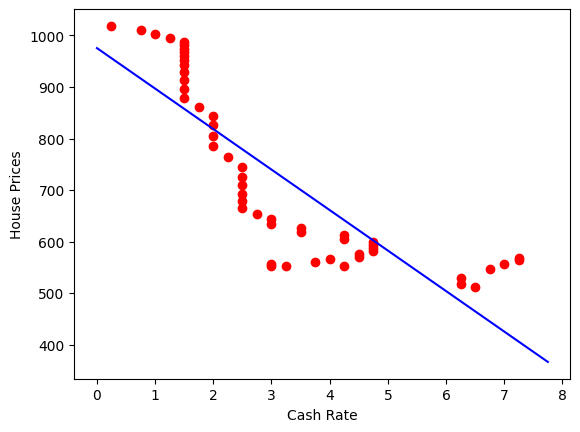

In [19]:
plt.plot(cash_rate, house_prices, 'ro')
plt.xlabel("Cash Rate")
plt.ylabel("House Prices")

# Here we create x values for "each hour of study" so we can plot the results
x_model = np.arange(0, 8, 0.25)
y_model = x_model * beta[1] + beta[0]  # Use our learned model to fit the line of best fit.

plt.plot(x_model, y_model, 'b-')

Predicting the actual scores, we can see our trained model is better than the intuited model from earlier.

In [20]:
predicted_prices = cash_rate * beta[1] + beta[0]
squared_error = np.sum((predicted_prices - house_prices) ** 2)
print("The squared error is {:.2f}".format(squared_error))

The squared error is 438881.87


#### Exercises

1. Remove the values with a cash rate above 6.0 and rerun the analysis. What $\beta$ values do you obtain?
2. Implement and run the following algorithm:


```
loop 100 times:
    obtain a sample of 50% of the data points
    compute the beta values
    
average all beta values obtained during the loop as the final beta values
```

This is an *ensemble* learner - it is great for removing the effect of outliers, as seen in the above data.


The squared error is 355102.81


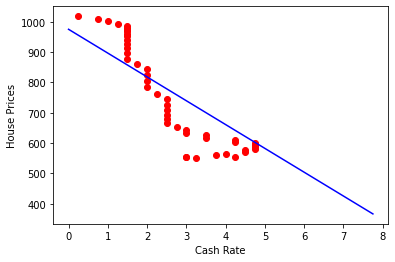

In [29]:
keep = cash_rate < 6
cash_rate = cash_rate[keep]
house_prices = house_prices[keep]

plt.plot(cash_rate, house_prices, 'ro')
plt.xlabel("Cash Rate")
plt.ylabel("House Prices")

# Here we create x values for "each hour of study" so we can plot the results
x_model = np.arange(0, 8, 0.25)
y_model = x_model * beta[1] + beta[0]  # Use our learned model to fit the line of best fit.

plt.plot(x_model, y_model, 'b-')
predicted_prices = cash_rate * beta[1] + beta[0]
squared_error = np.sum((predicted_prices - house_prices) ** 2)
print("The squared error is {:.2f}".format(squared_error))


In [31]:
# Question 2

# Store parameter versions here
models = []

n = len(cash_rate)

for i in range(100):
    
    # Choose random indexes
    # replace=True is better statistically, we will come back to it later on...
    random_indexes = np.random.choice(np.arange(n), size=int(n/2), replace=True)
    cash_rate_sample = cash_rate[random_indexes]
    house_prices_sample = house_prices[random_indexes]
    
    ones_sample = np.ones((len(cash_rate_sample)))
    X_sample = np.vstack([ones_sample, cash_rate_sample]).T

    Y_sample = house_prices_sample.reshape((len(house_prices_sample), 1))

    beta_sample = np.linalg.inv(X_sample.T.dot(X_sample)).dot(X_sample.T.dot(Y_sample))
    models.append(beta_sample)
# Average all parameters
final_model = np.mean(models, axis=0)
print(final_model)

[[1079.63294817]
 [-125.04884346]]


*For solutions, see `solutions/ols_basic_ensemble.py`*